# STARE-based Integrative Analysis of Diverse Data Using Dask Parallel Programming Demo Paper

## Preliminaries

In [49]:
import pystare as ps

from netCDF4 import Dataset

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf

import geodata as gd

import numpy

from PIL import Image
Image.MAX_IMAGE_PIXELS = None


import os
import sys
import glob
from io import BytesIO

import boto3
from botocore import UNSIGNED
from botocore.config import Config

import starepandas
import pandas
import geopandas
import matplotlib.pyplot as plt
import sqlalchemy
import shapely

%matplotlib inline
# %matplotlib notebook

In [57]:
def divert_stderr():
    sys.stderr = open('stderr.out','w')  
    return

def restore_stderr():
    sys.stderr.close()
    with open('stderr.out') as f:
        count = sum(1 for _ in f)
    if count > 0:
        print(count, 'warnings or errors encountered while stderr diverted. See stderr.out.')
    sys.stderr = sys.__stderr__
    return

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import cartopy.crs as ccrs
import cartopy.feature as cf

import numpy
import shapely

# Some helper functions for plotting & printing.

def mnmx(a):
    return numpy.amin(a),numpy.amax(a)
def span(a):
    return numpy.amax(a)-numpy.amin(a)

class figax_container(object):
    def __init__(self,figax,plot_options=None):
        self.fig = figax[0]
        self.ax  = figax[1]
        self.plot_options = plot_options
        return

def add_coastlines(figax,set_global=False):
    "Add coastlines to the plot."
    ax = figax.ax
    if set_global:
        ax.set_global()
    ax.coastlines()
    return figax

def hello_plot(
        spatial_index_values=None
        ,figax=None
        ,plot_options=None
        ,set_global=False
        ,set_coastlines=True
        ,show=True
        ,color=None
        ,lw=1
        ,dbg=0
        ,fixdateline=False
        ):

    if spatial_index_values is not None:
        # Calculate vertices and interconnection matrix
        lons,lats,intmat = ps.triangulate_indices(spatial_index_values)
        
        if dbg>0:
            print('lons: ',mnmx(lons))
            print('lats: ',mnmx(lats))
            # print('lons: ',lons)
            # print('lats: ',lats)
        
        # Make triangulation object & plot
        siv_triang = tri.Triangulation(lons,lats,intmat)
        # print('plot type triang: ',type(siv_triang))

    if figax is not None:
        plot_options = figax.plot_options
    
    if plot_options is None:
        if spatial_index_values is not None:
            mnx  = mnmx(lons)
            if fixdateline:
                s = span(lons)
                if s > 270:
                    clon = ((0.5 * (sum(mnx)+180))%360)-180
                else:
                    clon = 0.5*sum(mnx)
            else:
                clon = 0.5*sum(mnx)
            plot_options = {
                'projection':ccrs.PlateCarree(
                    central_longitude=clon
                    # ,central_latitude=0.5*(numpy.amin(lats)+numpy.amax(lats))
                                             )
            ,'transform':ccrs.Geodetic()}
            if dbg>0:
                print('hp-po central_longitude: ',clon)
        else:
            plot_options = {'projection':ccrs.PlateCarree()
                           ,'transform':ccrs.Geodetic()}

        
    if figax is None:
        figax = figax_container(plt.subplots(1,subplot_kw=plot_options),plot_options=plot_options)
        if set_global:
            figax.ax.set_global()
        if set_coastlines:
            figax.ax.coastlines()
    else:
        ax = figax.ax  
        
    if spatial_index_values is not None: 
        divert_stderr()
        figax.ax.triplot(siv_triang,c=color,transform=plot_options['transform'],lw=lw)
        restore_stderr()
    
    if show:
        plt.show()
        
    if dbg>0:
        return figax,lons,lat,intmat
    return figax

def hex16(i):
    return "0x%016x"%i

def lonlat_from_coords(coords):
    tmp = numpy.array(coords)
    lat=tmp[:,1]
    lon=tmp[:,0]
    return lon,lat

km  = 1 # Unit of length
deg = 1 # Unit of angle

# Set up the projection and transformation
proj         = ccrs.PlateCarree()
# proj        = ccrs.Robinson() # Drives matplotlib bug.
# proj        = ccrs.Mollweide() # Drives matplotlib bug.
transf       = ccrs.Geodetic()
plot_options = {'projection':proj,'transform':transf}

In [78]:
default_dpi = mpl.rcParamsDefault['figure.dpi']
mpl.rcParams['figure.dpi'] = 1.5*default_dpi

In [3]:
class merra2_sidecar(object):
    def __init__(self,cover_resolution = 0):
        self.nlat = 361
        self.nlon = 576
        self.dlat = 0.5 # or 180.0/(nlat-1)
        self.dlon = 5.0/8.0 # or 360.0/(nlon)
        self.lat1d = self.dlat*np.arange(self.nlat)-90.0
        self.lon1d = self.dlon*np.arange(self.nlon)-180.0
        self.dLatkm = self.dlat * gd.re_km/gd.deg_per_rad
        self.dLonkm  = self.dlon * gd.re_km/gd.deg_per_rad
        self.lat,self.lon = np.meshgrid(self.lat1d,self.lon1d)
        self.lat_flat     = self.lat.flatten()
        self.lon_flat     = self.lon.flatten()
        self.idx_ij       = np.arange(self.lat_flat.size,dtype=np.int64)
        self.resolution   = int(gd.resolution(self.dLonkm*2))
        self.cover_resolution = cover_resolution
        self.index        = ps.from_latlon(self.lat_flat,self.lon_flat,self.resolution)
        di = ps.spatial_increment_from_level(self.cover_resolution)
        self.cover        = [self.cover_resolution+(i*di) for i in range(8*(4**self.cover_resolution))]
        

## STARE HTM Geolocation

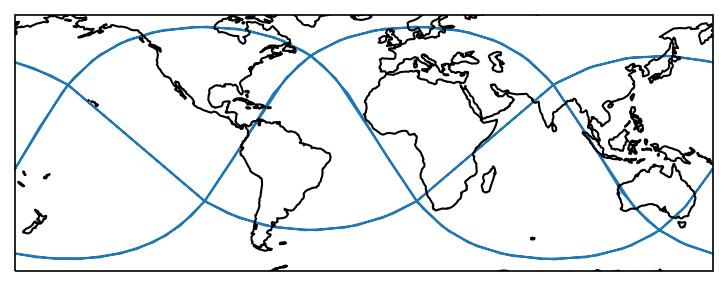

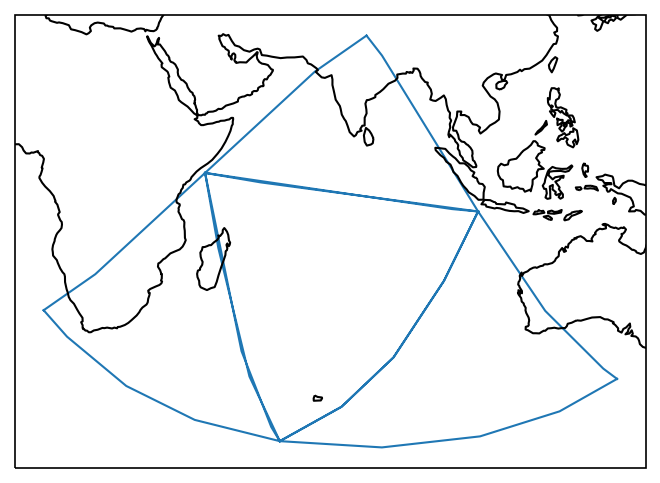

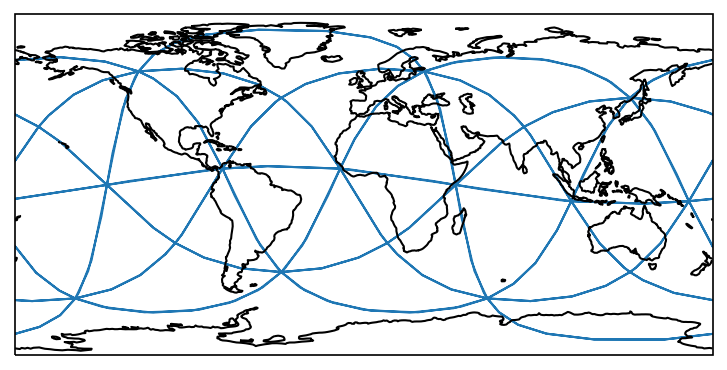

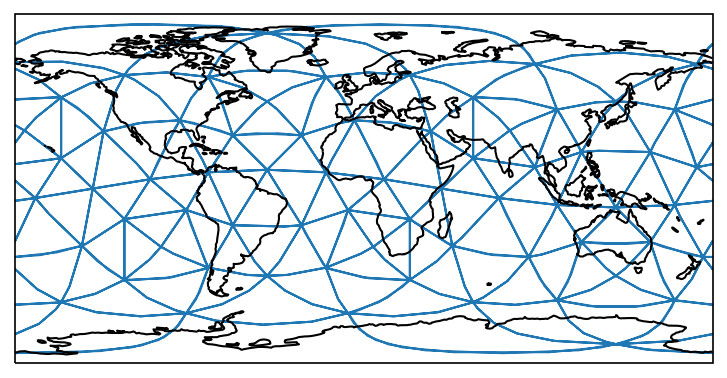

In [73]:
def trixels_at_level(cover_resolution = 0):
    di = ps.spatial_increment_from_level(cover_resolution)
    cover = [cover_resolution+(i*di) for i in range(8*(4**cover_resolution))]
    hello_plot(cover)
    return cover
    
cover = trixels_at_level(0)
cover = hello_plot([1+(i*ps.spatial_increment_from_level(1)) for i in range(4)])
cover = trixels_at_level(1)
cover = trixels_at_level(2)

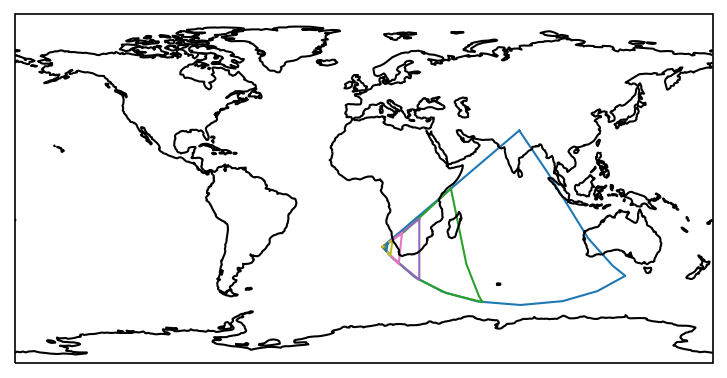

In [12]:
figax = hello_plot(show=False,set_global=True)
for i in range(10):
    figax = hello_plot([i],figax=figax,show=False)
plt.show()

## STARE HTM Trixel Neighborhoods

In [55]:
# Set longitude and latitude in degrees to the summit of Mauna Loa.
lon = -155.602778
lat =   19.479444

# Set the length scale of a neighborhood triangular element (trixel) about the location.
resolution_scale_km = 1000*km

# Determine the resolution, i.e. the level of the spatial quadtree, of that length scale.
spatial_resolution_level = int(ps.spatial_resolution_from_km(resolution_scale_km))

# Calculate the spatial index value.
spatial_id = ps.from_latlon([lat],[lon],spatial_resolution_level)

# Print to check.
print('resolution (%f km) ~ level = %i, (float %f)'%(resolution_scale_km
                                          ,spatial_resolution_level
                                          ,ps.spatial_resolution_from_km(resolution_scale_km)))
print('(lon,lat)=(%f,%f) -> spatial_id = %s'%(lon,lat,hex16(spatial_id[0])))
print()
print('Full spatial id:              %s'%(hex16(spatial_id[0])))
print('Geolocation part (bits 61-5): %s'%(hex16(spatial_id[0] & (~31))))
print('Resolution part  (bits  4-0): %s'%(hex16(spatial_id[0] & ( 31))))



resolution (1000.000000 km) ~ level = 3, (float 3.356144)
(lon,lat)=(-155.602778,19.479444) -> spatial_id = 0x2c2401f47797ec43

Full spatial id:              0x2c2401f47797ec43
Geolocation part (bits 61-5): 0x2c2401f47797ec40
Resolution part  (bits  4-0): 0x0000000000000003


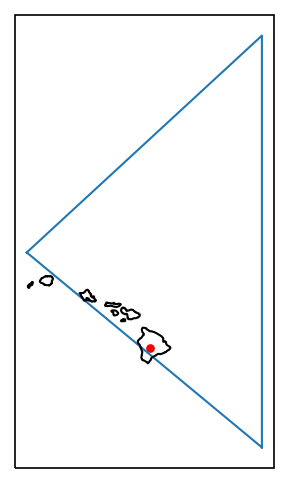

In [76]:
# Plot the trixel associated with the spatial index value
figax = hello_plot(show=False,plot_options=plot_options)
figax = hello_plot(spatial_id,figax=figax,show=False)

# Go to a finer resolution
if False:
    figax = hello_plot(spatial_id+1,figax=figax,show=False)

# Go to finer resolutions, all the way to level=10, 10km.
if False:
    for lvl in range(8):
        figax = hello_plot(spatial_id+2+lvl,figax=figax,show=False)

# Plot the geolocation (lon,lat) as a red dot.
figax.ax.scatter([lon],[lat],s=10,c='r',transform=plot_options['projection'])
plt.show()

## STARE Cover of a Granule

In [50]:
files=glob.glob('/home/jovyan/data/tmp/*_stare.nc')

In [51]:
files

['/home/jovyan/data/tmp/MOD05_L2.A2019337.1225.061.2019338011744_stare.nc',
 '/home/jovyan/data/tmp/MOD05_L2.A2019337.0000.061.2019337131745_stare.nc']

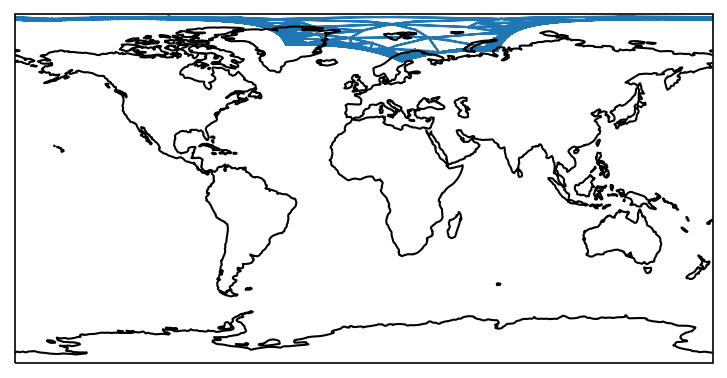

In [82]:
filename=files[0]
ds = Dataset(filename)
cover = ds['STARE_cover_5km'][:].flatten().astype(numpy.int64)
# cover = ds['STARE_index_5km'][:,:].flatten().astype(numpy.int64)
# print('ds shape: ',ds['Latitude_5km'].shape)
hello_plot(cover,set_global=True)

## STARE Region of Interest

In [72]:
path = geopandas.datasets.get_path('naturalearth_lowres')
world = geopandas.read_file(path)
# n_america = world[world.continent=='North America']
n_america = world[world.continent=='Oceania']
# n_america.drop('Fiji')

stare = starepandas.stare_from_gdf(n_america, level=7, force_ccw=True)
n_america = starepandas.STAREDataFrame(n_america, stare=stare)

# The trixels are just for visualization
n_america.set_trixels(inplace=True)
n_america.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,stare,trixels
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...","[1691242397565976583, 1691277581938065415, 169...",(POLYGON ((178.2630517930487 -17.9030132808031...
7,6909701,Oceania,Papua New Guinea,PNG,28020.0,"MULTIPOLYGON (((141.00021 -2.60015, 142.73525 ...","[1030761364714422278, 1034842751876726790, 103...",(POLYGON ((144.7874090166583 -6.02445533704830...
89,282814,Oceania,Vanuatu,VUT,723.0,"MULTIPOLYGON (((167.21680 -15.89185, 167.84488...","[1374196020673511431, 1374371942533955591, 137...",(POLYGON ((167.8392468143006 -16.4682369741067...
134,279070,Oceania,New Caledonia,NCL,10770.0,"POLYGON ((165.77999 -21.08000, 166.59999 -21.7...","[1398965818624049159, 1399141740484493319, 139...",(POLYGON ((166.4349709734367 -21.8909500010394...
135,647581,Oceania,Solomon Is.,SLB,1198.0,"MULTIPOLYGON (((162.11902 -10.48272, 162.39865...","[758328771630596103, 758504693491040263, 75875...",(POLYGON ((162.0092310794938 -10.9954141373886...


,pop_est,continent,name,iso_a3,gdp_md_est,geometry,stare,trixels
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...","[1691242397565976583, 1691277581938065415, 169...",(POLYGON ((178.2630517930487 -17.9030132808031...
7,6909701,Oceania,Papua New Guinea,PNG,28020.0,"MULTIPOLYGON (((141.00021 -2.60015, 142.73525 ...","[1030761364714422278, 1034842751876726790, 103...",(POLYGON ((144.7874090166583 -6.02445533704830...
89,282814,Oceania,Vanuatu,VUT,723.0,"MULTIPOLYGON (((167.21680 -15.89185, 167.84488...","[1374196020673511431, 1374371942533955591, 137...",(POLYGON ((167.8392468143006 -16.4682369741067...
134,279070,Oceania,New Caledonia,NCL,10770.0,"POLYGON ((165.77999 -21.08000, 166.59999 -21.7...","[1398965818624049159, 1399141740484493319, 139...",(POLYGON ((166.4349709734367 -21.8909500010394...
135,647581,Oceania,Solomon Is.,SLB,1198.0,"MULTIPOLYGON (((162.11902 -10.48272, 162.39865...","[758328771630596103, 758504693491040263, 75875...",(POLYGON ((162.0092310794938 -10.9954141373886...
136,4510327,Oceania,New Zealand,NZL,174800.0,"MULTIPOLYGON (((176.88582 -40.06598, 176.50802...","[1405404558716305415, 1405686033693016071, 140...",(POLYGON ((178.7303329145424 -38.1416177316210...
137,23232413,Oceania,Australia,AUS,1189000.0,"MULTIPOLYGON (((147.68926 -40.80826, 148.28907...","[1302666192216915975, 1302701376589004807, 130...",(POLYGON ((146.2500001315569 -44.4442171587261...


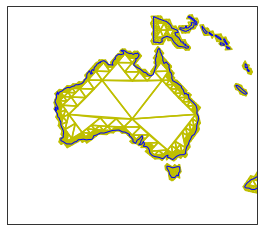

In [103]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
ax.grid(True)
ax.set_extent([100,170,-50,0],ccrs.Geodetic())
n_america.drop(0).plot(ax=ax, trixels=True, boundary=True, color='y', zorder=0) # Drop Fiji
n_america.plot(ax=ax, trixels=False, facecolor="none", edgecolor='blue', zorder=1)
plt.show()

## STARE Sidecar Files and Cataloguing

In [4]:
starepandas.__version__

'0+untagged.21.g239609c.dirty'

In [5]:
folder = '/home/jovyan/data/'
catalogue = starepandas.folder2catalogue(path=folder, 
                             granule_extension='hdf',
                             add_sf=True)


no sidecar found for /home/jovyan/data/MOD05_L2.A2019336.2310.061.2019337071934.hdf


In [6]:
catalogue.head()

,begining,ending,geom,granule_name,sidecar_name,stare_cover
0,2019-12-02 23:40:00,2019-12-02 23:45:00,"POLYGON ((151.85922 -0.93512, 151.84624 -1.024...",/home/jovyan/data/MOD05_L2.A2019336.2340.061.2...,/home/jovyan/data/MOD05_L2.A2019336.2340.061.2...,"[756604737398243331, 785878134976151556, 10133..."
1,2019-12-02 23:55:00,2019-12-03 00:00:00,"POLYGON ((129.30196 -52.27200, 129.22920 -52.3...",/home/jovyan/data/MOD05_L2.A2019336.2355.061.2...,/home/jovyan/data/MOD05_L2.A2019336.2355.061.2...,"[1990591035297759235, 1884756444054552580, 189..."
2,2019-12-02 23:30:00,2019-12-02 23:35:00,"POLYGON ((157.96890 34.89169, 157.96465 34.801...",/home/jovyan/data/MOD05_L2.A2019336.2330.061.2...,/home/jovyan/data/MOD05_L2.A2019336.2330.061.2...,"[875950127523561476, 887209126591987716, 89171..."
3,2019-12-02 23:20:00,2019-12-02 23:25:00,"POLYGON ((158.99763 70.64761, 159.02464 70.557...",/home/jovyan/data/MOD05_L2.A2019336.2320.061.2...,/home/jovyan/data/MOD05_L2.A2019336.2320.061.2...,"[3566850904877432835, 3503800510094245892, 350..."
4,2019-12-02 23:50:00,2019-12-02 23:55:00,"POLYGON ((140.56430 -35.90131, 140.52820 -35.9...",/home/jovyan/data/MOD05_L2.A2019336.2350.061.2...,/home/jovyan/data/MOD05_L2.A2019336.2350.061.2...,"[1299288492496388100, 1303792092123758596, 130..."


In [22]:
!ls /home/jovyan/data/*stare*| wc -l

11


In [25]:
len([i.size for i in catalogue['stare_cover']])

11

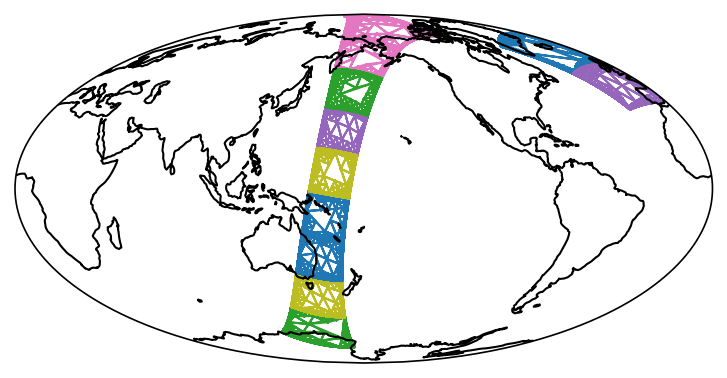

In [41]:
figax=hello_plot(set_global=True,show=False
                 ,plot_options={'projection':ccrs.Mollweide(central_longitude=180),'transform':ccrs.Geodetic()}
                )
for i in catalogue['stare_cover']:
    hello_plot(i.data,figax=figax,show=False)
plt.show()

In [77]:
# hello_plot(catalogue['stare_cover'][2].data,fixdateline=True)
# hello_plot(catalogue['stare_cover'][2].data,fixdateline=False)
# plt.show()
# catalogue['stare_cover'][1].size

## Searching the Catalogue

In [69]:
roi_stare = n_america[n_america.name=='Australia']


In [70]:
roi_stare = n_america[n_america.name=='Australia'].stare.iloc[0]

cover_intersects = catalogue.stare_intersects(roi_stare)
granule_subset = catalogue[cover_intersects].granule_name

msg = 'there are {} granules intersecting the ROI'.format(len(granule_subset))
print(msg)
granule_subset.head()

there are 2 granules intersecting the ROI


4     /home/jovyan/data/MOD05_L2.A2019336.2350.061.2...
10    /home/jovyan/data/MOD05_L2.A2019336.2345.061.2...
Name: granule_name, dtype: object

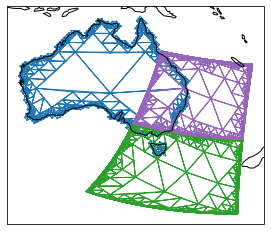

In [94]:
figax=hello_plot(set_global=False,show=False)
#                 ,plot_options={'projection':ccrs.Mollweide(central_longitude=180),'transform':ccrs.Geodetic()}
#                )
hello_plot(roi_stare,figax=figax,show=False)
hello_plot(catalogue['stare_cover'][4].data,figax=figax,fixdateline=False,show=False)
hello_plot(catalogue['stare_cover'][10].data,figax=figax,fixdateline=False,show=False)
plt.show()

In [102]:
# catalogue['stare_cover'][4].data,roi_stare

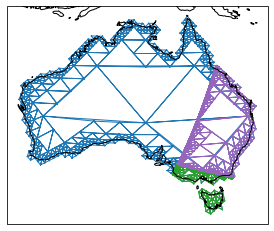

In [101]:
i4  = ps.intersect(roi_stare,catalogue['stare_cover'][4].data,1)
i10 = ps.intersect(roi_stare,catalogue['stare_cover'][10].data,1)

figax=hello_plot(set_global=False,show=False)
#                 ,plot_options={'projection':ccrs.Mollweide(central_longitude=180),'transform':ccrs.Geodetic()}
#                )
hello_plot(roi_stare,figax=figax,show=False)
hello_plot(i4,figax=figax,fixdateline=False,show=False)
hello_plot(i10,figax=figax,fixdateline=False,show=False)
plt.show()

## Subsetting the Data

## Dask Acceleration

### Dask Preliminaries

### Example Parallelization

### Trixel-based Integration

## Conclusion

### How to try STARE out